# Notebook for Generating Figures Used in Bolliger et al. (2024)

This notebook processes the outputs of pyCIAM into the numbers and figures included in the text of the accompanying manuscript.

In [1]:
import warnings

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import shared
import xarray as xr
from cartopy import crs as ccrs
from colorcet import cm
from exactextract import exact_extract, feature
from matplotlib import colors, rc_context, ticker
from matplotlib import pyplot as plt

## Setup

In [2]:
params = pd.read_json(shared.PATH_PARAMS)["values"]

In [25]:
DPI = "figure"
PLOT_TEXT = True
bl = "ssp370_medium"
iss = ["ssp370_medium_constant", "ssp370_medium_ant", "ssp370_medium_green"]
iss_labs = ["Uniform (1cm)", "AIS (1cm)", "GrIS (1cm)"]
iss_cols = ["coral", "dodgerblue", "limegreen"]
bl_col = "grey"
sel_ssp = "SSP2"
sel_iam = "IIASA"
sel_cases = ["noAdaptation", "optimalfixed"]
yrs = np.arange(params.model_start, 2101, 1)
res_unit = "adm1"

## Load and process data

### Load and process pyCIAM outputs

In [4]:
res = xr.open_zarr(shared.PATH_OUTPUTS).squeeze(drop=True)

# add NPV to results
res["npv"] = (
    (res.costs * ((1 / (1 + params.dr)) ** (res.year - params.npv_start)).clip(max=1))
    .sel(year=slice(params.npv_start, None))
    .sum("year")
)
gnpv = res.npv.sum("costtype").sum("adm1").load()

selres = res.sel(
    ssp=sel_ssp,
    case=sel_cases,
    iam=sel_iam,
)

costs2100 = selres.costs.sel(year=2100).sum("costtype").load()
npv = selres.npv.sum("costtype").load()

### Load and process SLIIDERS, SLR, other econ data

In [5]:
inputs = xr.open_zarr(shared.PATH_SLIIDERS)

slr = xr.open_zarr(shared.PATH_SLR_INT)
slr_scens = slr.scenario[
    ~(
        slr.scenario.str.contains("ant")
        | slr.scenario.str.contains("green")
        | slr.scenario.str.contains("constant")
    )
]
slr_ser = slr.sel(scenario=slr_scens, quantile=0.5, year=2100).gsl_msl05.to_series()

## Calculate cost data

In [6]:
cost_ser = costs2100.sum("adm1").sel(case=["optimalfixed", "noAdaptation"]).to_series()
cost_ser

case          scenario              
optimalfixed  ncc_is                    9.293709e+10
              ssp119_medium             1.733640e+11
              ssp119_medium_ant         1.742456e+11
              ssp119_medium_constant    1.741029e+11
              ssp119_medium_green       1.742317e+11
                                            ...     
noAdaptation  ssp585_low_green          6.478424e+12
              ssp585_medium             4.848148e+12
              ssp585_medium_ant         4.965769e+12
              ssp585_medium_constant    4.956114e+12
              ssp585_medium_green       4.961616e+12
Name: costs, Length: 66, dtype: float32

In [7]:
# Total Costs in 2100 by Scenario (SSP2, IIASA)
costs_df = (
    costs2100.to_dataframe()
    .reset_index()
    .pivot(index="adm1", columns=["scenario", "case"], values="costs")
)
costs_df.columns = [
    "costs2100_" + "_".join(col).strip() for col in costs_df.columns.values
]

# NPV by Scenario (SSP2, IIASA)
npv_df = (
    npv.to_dataframe()
    .reset_index()
    .pivot(index="adm1", columns=["scenario", "case"], values="npv")
)
npv_df.columns = ["npv_" + "_".join(col).strip() for col in npv_df.columns.values]

In [8]:
def calc_diffs(arr, baseline="no_pulse"):
    """Calculate the difference between pulse scenarios and baseline scenario."""
    if baseline == "constant":
        matchstr = "(?:green|ant|constant)"
    else:
        matchstr = "(?:green|ant)"
    out = arr.sel(scenario=arr.scenario.str.contains(matchstr))

    baseline_vals = (
        out.scenario.str.split("tmp", sep="_").sel(tmp=slice(2)).str.join("tmp", "_")
    )
    if baseline == "constant":
        baseline_vals = np.char.add(baseline_vals, "_constant")
    return out - arr.sel(scenario=baseline_vals).values

In [9]:
# Calculate Costs in 2100 difference values (SSP2, IIASA)
cdiff2100 = calc_diffs(costs2100)

# Calculate Costs in 2100 difference of AIS, GrIS from Uniform pulse values (SSP2, IIASA)
cdiff2100_uni = calc_diffs(costs2100, baseline="constant")

# Calculate NPV difference values (SSP2, IIASA)
npvdiff = calc_diffs(npv)

# Calculate NPV difference of AIS, GrIS from Uniform pulse values (SSP2, IIASA)
npvdiff_uni = calc_diffs(npv, baseline="constant")

# aggregate into 1 array
cdiff = xr.concat(
    (cdiff2100, cdiff2100_uni), dim=pd.Index(["no_pulse", "uniform"], name="baseline")
)
npvdiff = xr.concat(
    (npvdiff, npvdiff_uni), dim=pd.Index(["no_pulse", "uniform"], name="baseline")
)
diffs = xr.concat(
    (cdiff, npvdiff), dim=pd.Index(["costs_2100", "npv"], name="cost_type")
)

### NPV Totals for Paper Figs

In [20]:
(
    diffs.sel(
        case="optimalfixed", scenario=iss, baseline="no_pulse", cost_type="npv"
    ).sum("adm1")
    / 1e9
).to_series()

scenario
ssp370_medium_constant    58.339226
ssp370_medium_ant         63.376669
ssp370_medium_green       48.212327
Name: costs, dtype: float64

In [21]:
(gnpv.sel(case="optimalfixed", ssp="SSP2", iam="IIASA", scenario=bl) / 1e12).item()

9.745400636007176

## Join population/GDP values

In [22]:
valid_ctrys = inputs.country.values
valid_adm1s = np.unique(inputs.adm1)

# intermediate data file from SLIIDERS generation that contains country-level GDP and
# GDP per capita. We extract the 2020 values (most current available) in 2019
# constant USD
adm0_econ_data = (
    pd.read_parquet(
        shared.PATH_YPK_HIST,
        filters=[("year", "=", 2020), ("ccode", "in", valid_ctrys)],
        columns=["rgdpna_19", "pop"],
    )
    .rename(columns={"rgdpna_19": "gdp"})
    .droplevel("year")
)

In [23]:
cadm1 = gpd.read_file(shared.PATH_GADM, layer="ADM_1")
cadm1 = cadm1.loc[cadm1.GID_0.isin(valid_ctrys), ["GID_0", "GID_1", "geometry"]]

# drop hong kong and macao b/c they are treated as individual adm0 in SLIIDERS
cadm1 = cadm1.replace({"GID_1": {"CHN.HKG": "HKG", "CHN.MAC": "MAC"}})
cadm1["GID_0"] = cadm1.GID_0.where(cadm1.GID_1 != "HKG", "HKG").where(
    cadm1.GID_1 != "MAC", "MAC"
)

# correct Ghana typo
cadm1["GID_1"] = cadm1.GID_1.str.replace("GHA", "GHA.")

# figure out which adm1s have no adm1 equivalent in this dataset
only_adm0 = valid_ctrys[~np.isin(valid_ctrys, cadm1.GID_0.unique())]

# add these in
cadm0 = gpd.read_file(shared.PATH_GADM, layer="ADM_0").set_index("GID_0").geometry
cadm1 = pd.concat(
    (cadm1, cadm0.loc[only_adm0].reset_index().assign(GID_1=lambda x: x.GID_0))
).reset_index()

In [26]:
vec = feature.GeoPandasFeatureSource(cadm1)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Spatial reference system")
    gdp_adm1 = exact_extract(shared.PATH_GRIDDED_GDP, vec, "sum", progress=True)
    pop_adm1 = exact_extract(shared.PATH_LANDSCAN, vec, "sum", progress=True)

.: 100%|██████████| 100.0/100 [02:54<00:00,  1.74s/it]              
.: 100%|██████████| 100.0/100 [02:45<00:00,  1.65s/it]              


In [93]:
econ_data = pd.DataFrame(
    {
        "gdp": [i["properties"]["sum"] for i in gdp_adm1],
        "pop": [i["properties"]["sum"] for i in pop_adm1],
        "adm0": cadm1.GID_0.values,
    },
    index=cadm1.GID_1,
)

# calculate adm1:adm0 ratios for gdp and pop
econ_data = econ_data.join(
    econ_data.groupby("adm0")
    .sum()
    .rename(columns={"gdp": "gdp_adm0", "pop": "pop_adm0"}),
    on="adm0",
)

# XPI is the one example where GADM + wang&sun yields 0 GDP but sliiders has non-0
# so we give a gdp ratio of 1 for all of these cases. For all others, SLIIDERS
# yields 0 GDP as well so we will multiply 0 * 1 = 0.
# Same for IOT in pop_ratio
econ_data[["gdp_ratio", "pop_ratio"]] = (
    econ_data[["gdp", "pop"]] / econ_data[["gdp_adm0", "pop_adm0"]].values
)

# multiply ratios by SLIIDERS intermediate data for adm0 and calculate gdppc adm1
econ_data = econ_data[["adm0", "gdp_ratio", "pop_ratio"]].join(
    adm0_econ_data.rename(columns=lambda x: x + "_adm0"), on="adm0"
)


for col in ["gdp_ratio", "pop_ratio"]:
    econ_data[col] = econ_data[col].where(
        econ_data[col].notnull()
        | (
            (econ_data.index != econ_data.adm0)
            & (econ_data[col.split("_")[0] + "_adm0"] != 0)
        ),
        1,
    )

econ_data = (
    (econ_data[["gdp_ratio", "pop_ratio"]] * econ_data[["gdp_adm0", "pop_adm0"]].values)
    .rename(columns={"gdp_ratio": "gdp", "pop_ratio": "pop"})
    .assign(gdppc=lambda x: (x.gdp / x["pop"]).fillna(0))
)

assert econ_data.notnull().all().all()

In [94]:
# merge costs data with gdp data
scisms = xr.merge(
    [
        diffs.to_dataset(name="costs"),
        econ_data.loc[diffs.adm1].to_xarray().rename(GID_1="adm1"),
    ]
)

# calculate fractions
scisms["fgdp"] = (scisms.costs / scisms.gdp).fillna(0)

# when GDP is 0, replace fraction with 0, whether or not costs are also 0
scisms["fgdp"] = scisms.fgdp.where(~np.isinf(scisms.fgdp), 0)

# do the same for baseline costs
baseline_costs = xr.concat(
    (
        costs2100.drop_sel(scenario=diffs.scenario),
        npv.drop_sel(scenario=diffs.scenario),
    ),
    dim=pd.Index(["costs_2100", "npv"], name="cost_type"),
)
baseline_costs = xr.merge(
    [
        baseline_costs.to_dataset(name="costs"),
        econ_data.loc[diffs.adm1].to_xarray().rename(GID_1="adm1"),
    ]
)
baseline_costs["fgdp"] = (baseline_costs.costs / baseline_costs.gdp).fillna(0)
baseline_costs["fgdp"] = baseline_costs.fgdp.where(~np.isinf(baseline_costs.fgdp), 0)

## Create figs

### Create spatial figures

The actual figure displayed in the paper is stylistically modified via QGIS.

In [95]:
adm1_shps = cadm1.set_index("GID_1").geometry.loc[valid_adm1s]
map_proj = ccrs.Robinson().proj4_init


def plot_vals(
    arr,
    scen,
    fontsize=4,
    cost_type="npv",
    case="optimalfixed",
    baseline=None,
    ax=None,
    figsize=(8, 3),
    multiplier=100,
    cax_loc=None,
    title=None,
    add_sum=False,
    sum_plus=False,
    plot_text=PLOT_TEXT,
    **plot_kwargs,
):
    """Plot one map of SC-ISM."""
    to_plot = arr.sel(scenario=scen, case=case, cost_type=cost_type)
    if baseline is not None:
        to_plot = to_plot.sel(baseline=baseline)
    to_plot = to_plot.to_series() * multiplier

    if ax is None:
        fig, ax = plt.subplots(
            figsize=figsize, subplot_kw={"projection": ccrs.Robinson()}
        )
    if "legend" in plot_kwargs and plot_kwargs["legend"] and "cax" not in plot_kwargs:
        plot_kwargs["cax"] = ax.inset_axes(cax_loc)

    ax = (
        adm1_shps.to_frame()
        .join(to_plot)
        .to_crs(map_proj)
        .plot(column=to_plot.name, ax=ax, **plot_kwargs)
    )

    ax.axis("off")
    if plot_text:
        title_text = title
        if add_sum:
            title_text += "\n"
            if sum_plus:
                title_text += "+"
            this_sum = to_plot.sum() / multiplier
            if this_sum > 1e12:
                text = f"${this_sum / 1e12:.3} Tn"
            else:
                text = f"${this_sum / 1e9:.3} Bn"
            title_text += text
        ax.set_title(title_text, x=0, y=0.2, va="bottom", ha="left", fontsize=fontsize)
    return ax


def plot_maps(
    data_var,
    norm,
    lower_cbar_ticks,
    toplabel,
    bottomlabel,
    plot_text=PLOT_TEXT,
    cmap="coolwarm",
    multiplier=100,
    multiplier_raw=100,
    add_sum=False,
    fontsize=4,
):
    """Plot 5-figure panel maps of SC-ISM."""
    if data_var == "fgdp":
        kind = "normalized"
    else:
        kind = "absolute"

    with rc_context({"ytick.labelsize": fontsize, "xtick.labelsize": fontsize}):
        fig = plt.figure(figsize=(6.5, 4), constrained_layout=True)
        gs = plt.GridSpec(5, 4, figure=fig, height_ratios=[1, 1, 1, 1, 0.1])
        proj = ccrs.Robinson()
        ax1 = fig.add_subplot(gs[0, 1:3], projection=proj)
        ax2 = fig.add_subplot(gs[1, 1:3], projection=proj)
        ax3 = fig.add_subplot(gs[2, :3], projection=proj)
        ax4 = fig.add_subplot(gs[2, 1:], projection=proj)
        ax5 = fig.add_subplot(gs[3, :3], projection=proj)
        ax6 = fig.add_subplot(gs[3, 1:], projection=proj)
        cax = fig.add_subplot(gs[4, 1:3])

        top_legend_kwargs = {
            "format": ticker.FixedFormatter([0.1, 1, 10, 100]),
            "ticks": ticker.FixedLocator([0.1, 1, 10, 100]),
            "label": None,
        }
        bottom_legend_kwargs = {
            "orientation": "horizontal",
            "format": ticker.FixedFormatter(lower_cbar_ticks),
            "ticks": ticker.FixedLocator(lower_cbar_ticks),
            "label": None,
        }
        if plot_text:
            top_legend_kwargs["label"] = toplabel
            bottom_legend_kwargs["label"] = bottomlabel
        plot_vals(
            baseline_costs[data_var],
            bl,
            multiplier=multiplier_raw,
            legend=True,
            cmap="Purples",
            norm=colors.LogNorm(vmin=0.1, vmax=100, clip=True),
            ax=ax1,
            cax_loc=[1.1, 0, 0.05, 1],
            legend_kwds=top_legend_kwargs,
            add_sum=add_sum,
            title="(a)\n\nNPC (2005-2010)\nBaseline SLR",
            fontsize=fontsize,
            plot_text=plot_text,
        )
        plot_vals(
            scisms[data_var],
            bl + "_constant",
            multiplier=multiplier,
            baseline="no_pulse",
            norm=norm,
            cmap=cmap,
            ax=ax2,
            add_sum=add_sum,
            title="(b)\n\nUniform Pulse\nSC-ISM (+1cm)",
            sum_plus=True,
            plot_text=plot_text,
            fontsize=fontsize,
        )
        plot_vals(
            scisms[data_var],
            bl + "_ant",
            multiplier=multiplier,
            baseline="no_pulse",
            norm=norm,
            cmap=cmap,
            ax=ax3,
            add_sum=add_sum,
            title="(c)\n\nAIS Pulse\nSC-ISM (+1cm)",
            sum_plus=True,
            fontsize=fontsize,
            plot_text=plot_text,
        )
        plot_vals(
            scisms[data_var],
            bl + "_ant",
            multiplier=multiplier,
            baseline="uniform",
            norm=norm,
            cmap=cmap,
            ax=ax4,
            add_sum=add_sum,
            title="(e)\n\nAIS - Uniform\nSC-ISM",
            sum_plus=True,
            fontsize=fontsize,
            plot_text=plot_text,
        )
        plot_vals(
            scisms[data_var],
            bl + "_green",
            multiplier=multiplier,
            baseline="no_pulse",
            norm=norm,
            cmap=cmap,
            ax=ax5,
            add_sum=add_sum,
            title="(d)\n\nGrIS Pulse\nSC-ISM (+1cm)",
            sum_plus=True,
            fontsize=fontsize,
            plot_text=plot_text,
        )
        plot_vals(
            scisms[data_var],
            bl + "_green",
            multiplier=multiplier,
            baseline="uniform",
            norm=norm,
            cmap=cmap,
            ax=ax6,
            legend=True,
            cax=cax,
            legend_kwds=bottom_legend_kwargs,
            add_sum=add_sum,
            title="(f)\n\nGrIS - Uniform\nSC-ISM",
            sum_plus=True,
            fontsize=fontsize,
            plot_text=plot_text,
        )

        # save figure
        fig.savefig(shared.PATHS_MAPS[kind], dpi=DPI)
        return fig

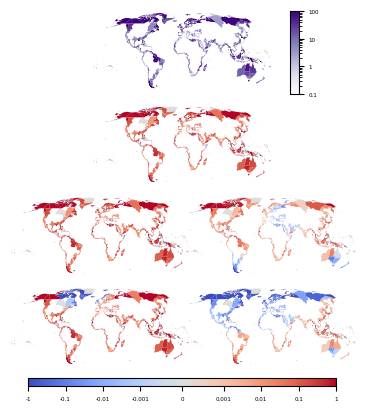

In [96]:
_ = plot_maps(
    "fgdp",
    colors.SymLogNorm(1e-3, vmin=-1, vmax=1),
    [-1, -0.1, -0.01, -0.001, 0, 0.001, 0.01, 0.1, 1],
    "NPC\n(% ADM1 GDP)",
    "$\\Delta$ NPC\n(% ADM1 GDP)",
    plot_text=PLOT_TEXT,
)

In [97]:
_ = plot_maps(
    "costs",
    colors.SymLogNorm(1, vmin=-1000, vmax=1000),
    [-1000, -100, -10, -1, 0, 1, 10, 100, 1000],
    "NPC\n(Billion $2019))",
    "$\\Delta$ NPC\n(Million $2019)",
    multiplier=1e-6,
    multiplier_raw=1e-9,
    add_sum=True,
    plot_text=PLOT_TEXT,
)

### Box-and-whisker

In [98]:
ssp_mtypes = ["o", "^", "s", "P", "*"]
bl_scens = [str(i) for i in baseline_costs.scenario.values if "ssp" in i]
bl_scens_labs = [s.upper().replace("_", " ") for s in bl_scens]

In [99]:
selcase = "optimalfixed"
npvt = gnpv.sel(case=selcase)
fig, ax = plt.subplots(figsize=(8, 6))
bvals = []
for pc, p in enumerate(["constant", "ant", "green"]):
    avals = []
    for i, s in enumerate(bl_scens):
        avals += [
            (npvt.sel(scenario=f"{s}_{p}") - npvt.sel(scenario=s)).values.flatten()
            / 1e9
        ]
    bvals += [np.concatenate(avals)]
bplot = ax.boxplot(bvals, vert=True, patch_artist=True, showfliers=False)
ax.set_axisbelow(True)
ax.grid(alpha=0.2, linestyle="--")

# fill with colors
for patch, color in zip(bplot["boxes"], iss_cols):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)
for median in bplot["medians"]:
    median.set_color("grey")

# Add points
for i, b in enumerate(bvals):
    ax.plot([i + 1] * len(b), b, "o", alpha=0.2, c=iss_cols[i])

# Highlight SSP3-7.0, SSP2, IIASA point
bl_idx = bl_scens.index("ssp370_medium")
sspiam_idx = 2
for i, b in enumerate(bvals):
    ax.plot(i + 1, b[10 * bl_idx + sspiam_idx], "o", alpha=0.6, c="black")


if PLOT_TEXT:
    ax.set_title("SC-ISM: Difference in Global NPV from Baseline SLR (2005-2100)")
    ax.set_ylabel("$Billion 2019 USD")
    ax.set_xticklabels(iss_labs)
else:
    ax.set_xticklabels([None, None, None])
plt.savefig(shared.PATH_BOXWHISKER, dpi=DPI)

In [100]:
# average % higher for AIS than GrIS, comparing like-to-like across scenarios
np.mean([(bv1 - bv2) / bv2 for bv1, bv2 in zip(bvals[1], bvals[2])])

np.float64(0.2936059556441622)

In [101]:
print(f"Uniform SC-ISM AR6 Max: {np.max(bvals[0])}")
print(f"AIS SC-ISM AR6 Max: {np.max(bvals[1])}")
print(f"GrIS SC-ISM AR6 Max: {np.max(bvals[2])}")

print(f"Uniform SC-ISM AR6 Min: {np.min(bvals[0])}")
print(f"AIS SC-ISM AR6 Min: {np.min(bvals[1])}")
print(f"GrIS SC-ISM AR6 Min: {np.min(bvals[2])}")

print(f"Uniform SC-ISM AR6 Median: {np.median(bvals[0])}")
print(f"AIS SC-ISM AR6 Median: {np.median(bvals[1])}")
print(f"GrIS SC-ISM AR6 Median: {np.median(bvals[2])}")
print(
    f"AIS > GrIS Avg. (%): {100 * (np.absolute(np.mean(bvals[1]) - np.mean(bvals[2])) / np.mean(bvals[2]))}"
)
print(
    f"AIS > GrIS Scenario-wise Avg. (%): {100 * np.mean([(bv1 - bv2) / bv2 for bv1,bv2 in zip(bvals[1], bvals[2])])}"
)

sel_idx = 10 * bl_idx + sspiam_idx
print(f"AIS SC-ISM SSP3-7.0/SSP2/IIASA: {bvals[1][sel_idx]}")
print(f"GrIS SC-ISM SSP3-7.0/SSP2/IIASA: {bvals[2][sel_idx]}")
print(
    f"AIS > GrIS SSP3-7.0/SSP2/IIASA (%): {100 * (np.absolute(bvals[1][sel_idx] - bvals[2][sel_idx]) / bvals[2][sel_idx])}"
)

Uniform SC-ISM AR6 Max: 73.24500667153906
AIS SC-ISM AR6 Max: 79.6371253518125
GrIS SC-ISM AR6 Max: 62.121378597386716
Uniform SC-ISM AR6 Min: 51.897633802379886
AIS SC-ISM AR6 Min: 56.6613835072793
GrIS SC-ISM AR6 Min: 43.83112837112598
Uniform SC-ISM AR6 Median: 57.82968029877637
AIS SC-ISM AR6 Median: 62.96950179686133
GrIS SC-ISM AR6 Median: 48.68688835007519
AIS > GrIS Avg. (%): 29.288596063951484
AIS > GrIS Scenario-wise Avg. (%): 29.36059556441622
AIS SC-ISM SSP3-7.0/SSP2/IIASA: 63.376669476867185
GrIS SC-ISM SSP3-7.0/SSP2/IIASA: 48.212327039154296
AIS > GrIS SSP3-7.0/SSP2/IIASA (%): 31.453247268893687


In [102]:
# create dataframe containing deciles of income per capita
decile_df = (
    scisms[["costs", "fgdp", "gdppc"]]
    .sel(
        cost_type="npv",
        baseline="no_pulse",
        scenario=[bl + "_" + i for i in ["constant", "ant", "green"]],
    )
    .reset_coords(drop=True)
    .to_dataframe()
)
decile_df = decile_df[(decile_df.fgdp > 0)]

quantiles = decile_df.groupby(["case", "scenario"]).gdppc.quantile(
    np.arange(0, 1.01, 0.1)
)

In [103]:
decile_df = decile_df.assign(
    decile=decile_df.groupby(["case", "scenario"])
    .apply(
        lambda x: pd.cut(x.gdppc, quantiles.loc[x.name], include_lowest=True).cat.codes
        + 1
    )
    .droplevel([0, 1])
).reset_index()

# rename scenarios for visualization
decile_df["scenario"] = decile_df.scenario.replace(
    {bl + "_constant": "Uniform", bl + "_ant": "AIS", bl + "_green": "GrIS"}
)

decile_df = decile_df.set_index(["case", "scenario", "adm1"])

# ensure no unmatched values
assert decile_df.decile.unique().min() == 1

In [104]:
for i, title in [
    ("optimalfixed", "Optimal Adaptation"),
    ("noAdaptation", "Reactive Adaptation"),
]:
    with sns.axes_style("whitegrid"):
        for j, kind in [("costs", "$2019"), ("fgdp", "% GDP")]:
            fig, ax = plt.subplots(figsize=(7, 2.5), constrained_layout=True)
            ax = sns.boxplot(
                decile_df.loc[i],
                x="decile",
                y=j,
                hue="scenario",
                palette=iss_cols,
                fliersize=0,
                ax=ax,
                legend=False,
                patch_artist=True,
                log_scale=True,
            )

            for p in ax.patches:
                p.set_alpha(0.7)

            if PLOT_TEXT:
                ax.set_ylabel(f"ADM1-level\nSC-ISM\n({kind})")
                ax.set_xlabel("2020 ADM1 Income Per Capital Decile")
                ax.set_title(
                    f"{title} (SSP3-7.0, SSP2, IIASA)",
                    ha="left",
                    x=0,
                    fontweight="bold",
                )
            else:
                ax.set_xlabel(None)
                ax.set_ylabel(None)

            fig.savefig(
                shared.DIR_FIGS
                / f"ypc19_DECILEgrouped_log10SCISM_{j}_ssp370_med_ssp2iiasa_byPulse_{i}.png",
                dpi=DPI,
            )

#### Calculate associated numbers for text

In [105]:
this = decile_df.loc["optimalfixed"]
m_lowest = this[this.decile == 1].fgdp.median()
m_highest = this[this.decile == 10].fgdp.median()
ratio = m_lowest / m_highest
print(f"Median Normalized SC-ISM, lowest decile: {m_lowest:.2%}")
print(f"Median Normalized SC-ISM, highest decile: {m_highest:.2%}")
print(f"Ratio: {ratio:.1f}")

Median Normalized SC-ISM, lowest decile: 1.50%
Median Normalized SC-ISM, highest decile: 0.04%
Ratio: 33.5


In [106]:
this_ais = this.loc["AIS"]
this_gris = this.loc["GrIS"]

ratios = {
    n: this_ais.loc[this_ais.decile == n, "fgdp"].mean()
    / this_gris.loc[this_gris.decile == n, "fgdp"].mean()
    for n in [8, 9, 10]
}
print(ratios)

{8: np.float64(1.0819944157420944), 9: np.float64(1.3782636532551384), 10: np.float64(0.9896090209163468)}


In [107]:
this = decile_df.loc["noAdaptation"]
m_lowest = this[this.decile == 1].fgdp.median()
m_highest = this[this.decile == 10].fgdp.median()
ratio = m_lowest / m_highest
print(f"Median Normalized SC-ISM, lowest decile: {m_lowest:.2%}")
print(f"Median Normalized SC-ISM, highest decile: {m_highest:.2%}")
print(f"Ratio: {ratio:.1f}")

Median Normalized SC-ISM, lowest decile: 42.09%
Median Normalized SC-ISM, highest decile: 0.28%
Ratio: 149.0


### Global Optimal Strategy

In [108]:
segshp = inputs[["seg_lon", "seg_lat", "seg"]].to_dataframe()
segshp = segshp.groupby("seg")[["seg_lon", "seg_lat"]].first()
segshp = gpd.GeoSeries.from_xy(
    segshp.seg_lon, segshp.seg_lat, crs="EPSG:4326", name="geometry"
)

name_key = {
    0: "No Action (reactive retreat only)",
    1: "Protect (10-year extreme water level)",
    2: "Protect (100-year extreme water level)",
    3: "Protect (1,000-year extreme water level)",
    4: "Protect (10,000-year extreme water level)",
    5: "Retreat (1-year extreme water level)",
    6: "Retreat (10-year extreme water level)",
    7: "Retreat (100-year extreme water level)",
    8: "Retreat (1,000-year extreme water level)",
    9: "Retreat (10,000-year extreme water level)",
}

oc = segshp.to_frame().join(
    res.sel(iam=sel_iam, ssp=sel_ssp, scenario=bl).optimal_case.to_series()
)
oc["optimal_case_str"] = oc.optimal_case.replace(name_key)
oc = oc.sort_values("optimal_case")

In [109]:
fig, ax = plt.subplots(
    figsize=(6.4, 3),
    subplot_kw={"projection": ccrs.Robinson()},
    constrained_layout=True,
)
cmaps = ["grey", cm.linear_ternary_blue_0_44_c57_r, cm.linear_ternary_red_0_50_c52_r]
locs = [0.3, 0.5, 0.725]
for ix, kind in enumerate(["No Action", "Protect", "Retreat"]):
    this = oc[oc.optimal_case_str.str.contains(kind)]
    names = this.groupby(this.optimal_case).first().optimal_case_str
    ax = this.plot(
        column="optimal_case",
        categorical=True,
        cmap=cmaps[ix],
        legend=True,
        ax=ax,
        legend_kwds={
            "bbox_to_anchor": (locs[ix], 0.09),
            "bbox_transform": fig.transFigure,
            "loc": "center",
            "fontsize": 4,
            "markerscale": 0.2,
        },
        s=0.1,
    )
    legend = ax.get_legend()
    [
        leg.set_text(names[int(leg.get_text())])
        for ix, leg in enumerate(legend.get_texts())
    ]
    if ix < 2:
        ax.add_artist(ax.get_legend())
ax.coastlines(alpha=0.5)
ax.axis("off")
fig.savefig(shared.DIR_FIGS / "adaptation-map.png", dpi=DPI)

/opt/conda/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
